In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME).cuda()
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME, torch_dtype=torch.bfloat16).cuda().eval()

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def _create_token_tree(
    expansion_config: Sequence[int],
    prompt: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    has_kv_cache: bool = False,
):
    """Create token tree following Figure 3 in the paper.

    We don't need "real" tokens for our experiments - just
    random integers would work too - but might as well.

    Figure 3 illustrates the <k1, k2, ...> expansion approach they
    use to create token trees. We can use each of the top_k tokens from
    a single model to create the same tree structure.

    Args:
        expansion_config: A sequence of integers representing how much to
            branch at each generation step.
        prompt: Initial prompt.
        tokenizer: HF tokenizer.
        model: HF generative model.
    """
    assert expansion_config
    current_tree = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
    if has_kv_cache:
        assert tokenizer.add_bos_token
        current_tree = current_tree[:, 1:]
    else:
        current_tree = current_tree[:, :-1]
    # assert current_tree.shape[-1] == 4
    for k in expansion_config:
        output = model.generate(
            current_tree,
            max_new_tokens=1,
            return_dict_in_generate=True,
            output_scores=True,
        )
        # Take the top_k tokens from the 1 generation step we've done
        top_k = torch.topk(output.scores[-1], k=k, dim=-1).indices.reshape(-1, 1)
        current_tree = torch.repeat_interleave(current_tree, k, dim=0)
        # Join the top_k tokens to the current tree
        current_tree = torch.cat((current_tree, top_k), dim=-1)

    return current_tree

In [14]:
import torch

def _invert_4d_attention_mask(attention_mask: torch.Tensor, kv_cache_num_tokens: int=0) -> torch.Tensor:
    """For 4D masks, new HF requires us to invert the mask so it doesn't modify it at all."""
    # The attention mask must have last 2 dims shape [current seq len, KV cache size + current seq len]
    # So we prepend a tensor of 1s to allow attending to the full KV cache
    assert attention_mask.dim() == 4
    if kv_cache_num_tokens > 0:
        attention_mask = torch.cat(
            (
                torch.ones(
                    attention_mask.shape[0],
                    attention_mask.shape[1],
                    attention_mask.shape[2],
                    kv_cache_num_tokens,
                ).to(device),
                attention_mask,
            ),
            dim=-1,
        )
    # Invert the mask: 0s to -inf and 1s to 0 (0 means attention allowed)
    min_dtype = torch.finfo(torch.float32).min
    attention_mask.masked_fill_(attention_mask == 0, min_dtype)
    attention_mask.masked_fill_(attention_mask == 1, 0.0)
    return attention_mask

def construct_tree_model_inputs(sequences):
    # input_1 = torch.unique(torch.flatten(sequences), sorted=False)
    flat = torch.flatten(sequences).tolist()
    unique = []
    for tok in flat:
        if tok not in unique:
            unique.append(tok)
    # input is list of unique tokens
    input_1 = torch.tensor([unique]).to(device)

    a = input_1.shape[-1]
    mask_1 = np.zeros((a, a), dtype=np.float32)
    positions = [-1] * len(unique)
    
    for seq in sequences:
        branch_progress = []
        for (pos, tok) in enumerate(seq):
            input_1_idx = unique.index(tok)
            positions[input_1_idx] = pos
            branch_progress.append(input_1_idx)
            for idx in branch_progress:
                mask_1[input_1_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device)
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_1, mask_1, position_ids_1)

In [15]:
def _create_dummy_kv_cache(
    kv_cache_num_tokens: int,
    batch_size: int,
    num_attention_heads: int,
    hidden_size: int,
    num_layers: int,
):
    k = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    v = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    return tuple((k, v) for _ in range(num_layers))

In [16]:
from torch.nn.attention import SDPBackend, sdpa_kernel

def time_normal(input_ids, model: AutoModelForCausalLM, kv_cache=None):
   with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
        with torch.autocast(device_type='cuda', dtype=torch.float16), torch.inference_mode():
            model(input_ids=input_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

def time_tree(input_ids, mask, position_ids, model: AutoModelForCausalLM, kv_cache=None):
    with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
        with torch.autocast(device_type='cuda', dtype=torch.float16), torch.inference_mode():
            model(input_ids=input_ids, attention_mask=mask, position_ids=position_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

In [17]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True,
    'with_stack': True,
    'on_trace_ready': torch.profiler.tensorboard_trace_handler('./log'),
}



def print_normal_profile_stats(input, model):
    # with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for _ in range(_N_ITERATIONS):
                model(input_ids=input)
                prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

def print_tree_profile_stats(input, mask, position_ids, model):
    # with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for _ in range(_N_ITERATIONS):
                model(input_ids=input, attention_mask=mask, position_ids=position_ids)
                prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [19]:
expansion_config = (7, 1, 1, 1, 1, 1, 1, 1, 1)

# del llm
# llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME).cuda().eval()
token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
)

# time_normal(token_tree, llm)
# print_normal_profile_stats(token_tree, llm)

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
time_tree(tree_input, tree_mask, tree_position_ids, llm)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/transformers/models/llama/modeling_llama.py:649: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:607.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/transformers/models/llama/modeling_llama.py:649: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  attn_output = torch.nn.functional.scaled_dot_product_attent

RuntimeError: No available kernel. Aborting execution.

In [10]:
print(token_tree.shape)
# tree_input.shape

torch.Size([7, 11])


In [69]:
# Optionally use the context manager to ensure one of the fused kernels is run
import torch.nn.functional as F
query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
mask = torch.rand(32, 1, 128, 128, dtype=torch.float16, device="cuda")
with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    F.scaled_dot_product_attention(query,key,value, mask)

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [21]:
from transformers import utils

utils.is_flash_attn_2_available()

True

In [4]:
import torch


params = torch.backends.cuda.SDPAParams(
    torch.ones(1, 1, 3, 8, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 3, 8, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 3, 8, dtype=torch.float16).cuda(),
    # None,
    torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    0.0,
    False
)

torch.backends.cuda.can_use_flash_attention(params, debug=True)

[W sdp_utils_cpp.h:269] Warning: Both fused kernels do not support non-null attn_mask. (function check_for_attn_mask)


False

In [20]:
# Measure max memory allocated
import gc

def reset_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()

def end_memory_collection():
    torch.cuda.synchronize()
    max_mem_gb = torch.cuda.max_memory_allocated() / 1024**3
    return max_mem_gb

token_tree = _create_token_tree([2, 2, 2], "The good dog is", tokenizer, ssm)
reset_memory()
time_normal(token_tree, llm, kv_cache=None)
seq_max_mem_gb = end_memory_collection()

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
reset_memory()
time_tree(input_ids=tree_input, mask=tree_mask, position_ids=tree_position_ids, model=llm, kv_cache=None)
tree_max_mem_gb = end_memory_collection()

print(f"Normal: {seq_max_mem_gb} GB")
print(f"Tree: {tree_max_mem_gb} GB")

past key values None
past key values None
past key values None
Normal: 19.76176118850708 GB
Tree: 19.75322389602661 GB


In [75]:
import torch.utils.benchmark as benchmark
import numpy as np

N_ITERATIONS = 32

tree_widths = [4] #range(1, 4)
sequential_times = []
tree_times = []

kv_cache_num_tokens = 128

for tree_width in tree_widths:
    expansion_config = (32, 2, 2, 1, 1, 1)

    token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)

    batch_size=np.prod(expansion_config)
    # kv_cache_sequential = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=batch_size,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model, kv_cache)",
        setup="from __main__ import time_normal",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': token_tree,
            'model': llm,
            'kv_cache': None
        },
        label="Sequential"
    )
    sequential_measurement = sequential_timer.blocked_autorange(min_run_time=1)
    # sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    # kv_cache_tree = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=1,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    print(tree_input, tree_mask, tree_position_ids)
    # Required for 4D mask support in new HF
    tree_mask = _invert_4d_attention_mask(tree_mask, kv_cache_num_tokens)

    # tree_timer = benchmark.Timer(
    #     stmt="time_tree(input_ids, mask, position_ids, model, kv_cache)",
    #     setup="from __main__ import time_tree",
    #     num_threads=torch.get_num_threads(),
    #     globals={
    #         'input_ids': tree_input,
    #         'mask': tree_mask,
    #         'position_ids': tree_position_ids,
    #         'model': llm,
    #         'kv_cache': None
    #     },
    #     label="Tree"
    # )
    # tree_measurement = tree_timer.timeit(N_ITERATIONS)
    # tree_times.append(tree_measurement.times[-1])
    
    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tensor([[    1,    31,   487,   284,   391,  1711, 29892],
        [    1,    31,   487,   571,  1705, 29889,   510],
        [    1,    31,   598,   261, 29892,   322,   278],
        [    1,    31,   598, 29899,   262, 29899, 29874],
        [    1,    30, 30088, 30088, 29871, 29906, 29871],
        [    1,    30, 30088, 29906, 29906, 29906, 29906],
        [    1,    30, 29906, 29941, 29906, 29906, 29906],
        [    1,    30, 29906, 29906, 29906, 29889,    13],
        [    1,    28, 29879,   413, 29889, 29871, 29945],
        [    1,    28, 29879,   310,   593, 29873,   322],
        [    1,    28,   645,  1371,  4078,  1371,  4078],
        [    1,    28,   645,   599,   367,  4208, 29889],
        [    1,    29,  4167,   575,   299, 29879,   299],
        [    1,    29,  4167,  4167, 29889,    13,  1576],
        [    1,    29, 29879,  4167,  4167,  4167, 29889],
        [    1,    29, 29879,  4004,  4004,  4004,  4004],
        [    1,    25, 11587,  5867, 29871, 29906, 29889

In [76]:
sequential_measurement.times

[0.07458824850618839,
 0.07633656449615955,
 0.07581533119082451,
 0.07572932541370392,
 0.07584896497428417,
 0.0757243912667036,
 0.07565928436815739,
 0.07604918070137501,
 0.07560066692531109,
 0.07736724242568016,
 0.08180560730397701,
 0.08228574879467487,
 0.08087449707090855]

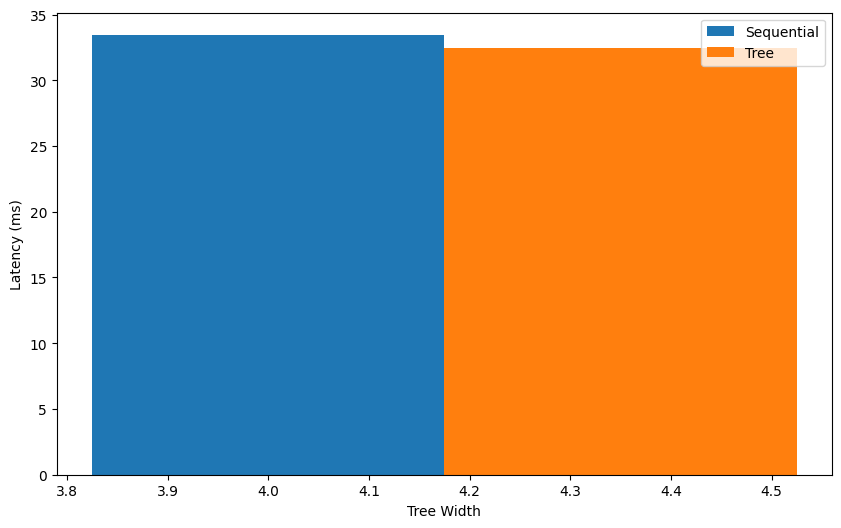

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 6))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Width")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [10]:
import metrics
from transformers import AutoConfig

mistral_7b_config = AutoConfig.from_pretrained("mistralai/Mistral-7B-v0.1")

metrics.identify_compute_memory_bound(
    gpu=metrics.T4,
    token_batch=torch.ones(1, np.sum(np.cumprod(expansion_config))),
    dtype=torch.float32,
    num_layers=mistral_7b_config.num_hidden_layers,
    d_model=mistral_7b_config.hidden_size,
    n_head=mistral_7b_config.num_attention_heads,
    vocab_size=mistral_7b_config.vocab_size,
    kv_cache_token_count=0
)

Memory-bound: arithmetic intensity 7.448872654272583 < 27.0


/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
